In [11]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

from absl import app
from absl import flags
import cv2
import os.path as osp
import sys
sys.path.insert(0,'third_party')
import pdb
import time
import numpy as np
import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import argparse
from omegaconf import OmegaConf
from nnutils.train_utils import v2s_trainer
import matplotlib.pyplot as plt
from nnutils.geom_utils import *
import os
opts = flags.FLAGS

def main(_):
    torch.cuda.set_device(opts.local_rank)
    torch.manual_seed(0)
    torch.cuda.manual_seed(1)
    torch.manual_seed(0)
    
    
    # override default config from cli
    extra_opt = OmegaConf.load(opts.config)
    trainer = v2s_trainer(opts)
    data_info = trainer.init_dataset()  
    trainer.define_model(data_info,extra_opt) 
    trainer.init_training()
    # import pdb;pdb.set_trace()
    trainer.train()




In [147]:
seqname = 'camel'
logname = f'eval-{seqname}-anim'
num_bones = 50
opts(['manipulate.ipynb'])
opts.seqname = seqname
opts.logname = logname
opts.num_bones = num_bones
opts.config = 'image.yaml'

In [148]:
extra_opt = OmegaConf.load(opts.config)
trainer = v2s_trainer(opts)
data_info = trainer.init_dataset()  
trainer.define_model(data_info,extra_opt) 
model = trainer.model
# model.load_bones('logdir/'+logname+'/')

# workers: 2
# pairs: 2
init:0, end:-1
89 pairs of images
# workers: 2
# pairs: 2
init:0, end:-1
89 pairs of images
init:0, end:-1
89 pairs of images
Number of points at initialisation :  50000
num_bones: 50


/home/tingyang/miniconda3/envs/DGS_my/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tingyang/miniconda3/envs/DGS_my/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
model.num_bones

50

In [15]:

model.load_bones('logdir/'+logname+'/')

In [149]:
# model.load_bones('logdir/cptest-snail-1/')
model.gaussians.load_ply(f'logdir/{logname}/checkpoints/epoch_init.ply')

38701 points loaded


In [150]:
print(model.bones_rts_frame.shape)
print(model.bones.shape)

torch.Size([90, 50, 6])
torch.Size([50, 10])


In [30]:
def show(fid=0,theta=0.,fai=0.,canonical=False):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    
    rgb = model.visualize(fid,theta,fai,canonical=canonical,bone_color=False)
    bone = model.visualize(fid,theta,fai,canonical=canonical,bone_color=True)
    
    ax1.imshow(rgb)
    ax1.set_title('RGB')
    ax2.imshow(bone)
    ax2.set_title('BONE')
    
    plt.tight_layout()
    plt.show()

In [ ]:
target_path = 'novel_motion/'+seqname
print(target_path)
if not os.path.isdir(target_path):
    os.makedirs(target_path)
model.save_imgs(target_path,0,0,novel_cam=True,save_video=True,use_deform=True,frame_bone=True,bone_color=False,camera_axis=np.pi*(0.5), fai=-0.*np.pi,fixed_frame=-1,postfix='-1_n',rp=True,seqname=seqname)

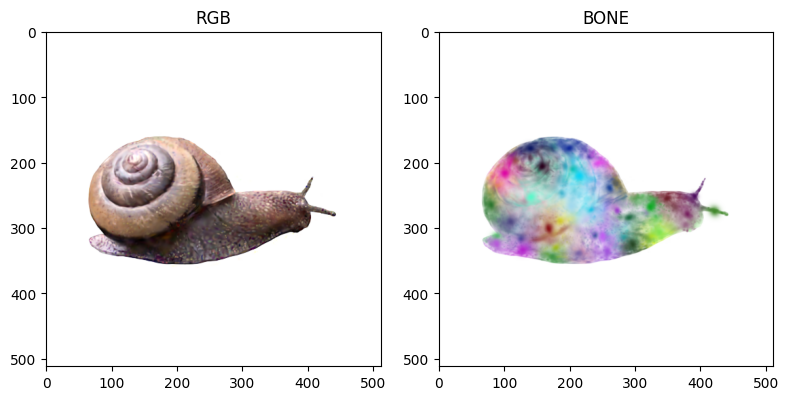

In [19]:
show(fid=0,theta=np.pi*0.,fai=0.0*np.pi,canonical=False)

In [31]:
print(model.bones_rts_frame.shape)
print(model.bones.shape)
print(model.save_dir)

torch.Size([95, 50, 6])
torch.Size([50, 10])
logdir/eval-snail-1


In [178]:
model.save_bones()


In [25]:
model.bones.shape

torch.Size([50, 10])

In [151]:
reinit_bones(model, model.gaussians.get_xyz, 50)

In [175]:

with torch.no_grad():
    model.bones_rts_frame.data[...] = 0.

In [153]:
torch.argsort(model.bones[:,1],descending=True)



tensor([32, 45, 21, 41, 42, 18, 44, 35, 23,  1, 26, 11, 31,  9, 16, 49, 13, 22,
         8,  3, 17, 46, 36,  0, 38, 20, 48, 12, 19, 14, 29, 40, 37,  2, 24, 47,
         5, 28, 27, 33,  4,  7, 15,  6, 25, 10, 34, 43, 39, 30],
       device='cuda:0')

In [154]:
t = torch.arange(0,model.bones_rts_frame.shape[0],dtype=torch.float32).cuda()
t

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88., 89.], device='cuda:0')

In [8]:
with torch.no_grad():
    model.gaussians._xyz[:,2]-=model.gaussians._xyz[:,2].mean()

In [92]:
#raven
with torch.no_grad():
    target = torch.logical_and(model.bones[:,1]>0.05,model.bones[:,2]>-0.1)
    model.bones_rts_frame.data[:,target,3] = torch.sin((t/30.*np.pi))[...,None]*(model.bones[target,2]/6.+0.15)[None,...]*3.

In [176]:
with torch.no_grad():
    target = torch.logical_and(model.bones[:,1]>0.0,model.bones[:,2]<-0.1)
    #model.bones_rts_frame.data[:,:,1] = torch.cos((t/10.*np.pi))[...,None]*(model.bones[:,1]*0.+0.1)[None,...]*1.
    model.bones_rts_frame.data[:,target,3] += torch.cos((t/10.*np.pi))[...,None]*(model.bones[target,1]+0.1)[None,...]*1.
    #model.bones_rts_frame.data[:,:,3] = torch.sin((t/10.*np.pi))[...,None]*(model.bones[:,1]+0.1)[None,...]*1.
    target = torch.logical_and(model.bones[:,1]<0.3,model.bones[:,2]>0.25)
    model.bones_rts_frame.data[:,target,3] += torch.cos((t/10.*np.pi))[...,None]*(model.bones[target,1]+0.1)[None,...]*1.

In [125]:
#ostrich
with torch.no_grad():
     target = [49,20,12]
     target1 = model.bones[:,1]>-0.05
     model.bones_rts_frame.data[:,target,1] = 0.5
     model.bones_rts_frame.data[:,target1,2] = -torch.sin((t/10.*np.pi))[...,None]*(model.bones[target1,1]*0.+0.15)[None,...]*4.
     model.bones_rts_frame.data[:,target,2] = torch.sin((t/10.*np.pi))[...,None]*(model.bones[target,1]*3+0.1)[None,...]*0.
     model.bones_rts_frame.data[:,target,3] = torch.sin((t/10.*np.pi))[...,None]*(model.bones[target,1]*1+0.1)[None,...]*0.6
     model.bones_rts_frame.data[:,target,1] = torch.sin((t/10.*np.pi))[...,None]*(model.bones[target,1]+0.1)[None,...]*1.
     
     # model.bones_rts_frame.data[:,[30,20,14],1] =0.5
     # model.bones_rts_frame.data[:,[30,20,14],2] =0.5

In [142]:
#penguin
with torch.no_grad():
    target = torch.logical_and(model.bones[:,2]>0.05,model.bones[:,1]>-0.9)
    model.bones_rts_frame.data[:,target,4] = torch.sin((t/11.5*np.pi))[...,None]*(model.bones[target,2]*1+0.1)[None,...]*2.
    target = torch.logical_and(model.bones[:,2]<-0.2,model.bones[:,1]>-0.9)
    model.bones_rts_frame.data[:,target,4] = -torch.sin((t/11.5*np.pi))[...,None]*(model.bones[target,2]+0.2)[None,...]*2.


In [179]:
target_path = 'novel_motion/'+seqname
if not os.path.isdir(target_path):
    os.makedirs(target_path)
model.save_imgs(target_path,0,0,fixed_cam=True,save_img=False,use_deform=True,frame_bone=True,bone_color=False,camera_axis=np.pi*(1.2), fai=-0.*np.pi,fixed_frame=-1,postfix='_anim2')

100%|██████████| 90/90 [00:01<00:00, 46.56it/s]


[array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], dtype=float32),
 array([[[1., 1., 1.],
         [1., 1.,

In [22]:
#shark
with torch.no_grad():
    model.bones_rts_frame.data[:,model.bones[:,2]<-0.05,4] = torch.sin((t/10.*np.pi))[...,None]*(-0.05-model.bones[model.bones[:,2]<-0.05,2])[None,...]*-3.
    model.bones_rts_frame.data[:,model.bones[:,2]<-0.05,3] = torch.sin((t/10.*np.pi))[...,None]*(-0.05-model.bones[model.bones[:,2]<-0.05,2])[None,...]*-3.
    model.bones_rts_frame.data[:,model.bones[:,2]>0.05,4] = torch.sin((t/10.*np.pi))[...,None]*(-0.05+model.bones[model.bones[:,2]>0.05,2])[None,...]*-3.
    

50 torch.Size([1, 1, 600]) torch.Size([1, 600])


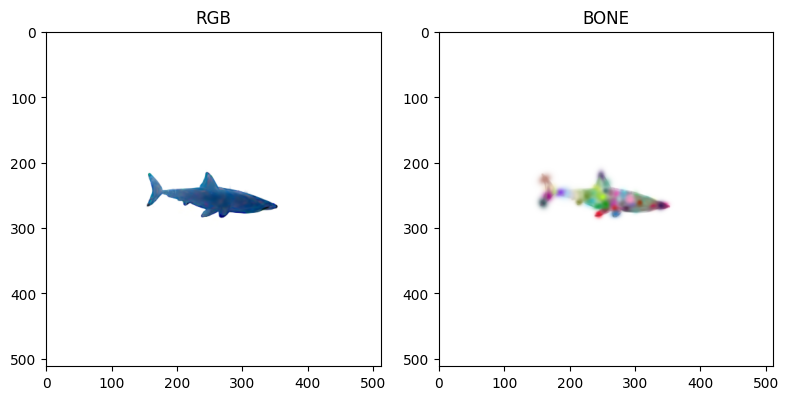

In [12]:
show(22,theta=np.pi*0.,fai=np.pi*0.,canonical=False)

In [ ]:
seqname = 'zongxiong'
logname = f'eval-{seqname}-1'
num_bones = 50
opts(['manipulate.ipynb'])
opts.seqname = seqname
opts.logname = logname
opts.num_bones = num_bones
opts.config = 'image.yaml'
extra_opt = OmegaConf.load(opts.config)
trainer = v2s_trainer(opts)
data_info = trainer.init_dataset()  
trainer.define_model(data_info,extra_opt) 
model = trainer.model
model.load_bones('logdir/'+logname+'/')
model.gaussians.load_ply(f'logdir/{logname}/checkpoints/epoch_init.ply')
target_path = 'logdir/'+logname+'/rendered_fix'
if not os.path.isdir(target_path):
    os.makedirs(target_path)
model.save_imgs(target_path,0,0,fixed_cam=True,save_img=False,frame_bone=True,camera_axis=np.pi*(0.1))

In [243]:

target_path = 'novel_motion/'+seqname
if not os.path.isdir(target_path):
    os.makedirs(target_path)

In [ ]:
model.save_imgs(target_path,0,0,fixed_cam=True,save_video=False,frame_bone=True,bone_color=False,camera_axis=np.pi*(0.6), fai=-0.1*np.pi)

In [102]:
model.save_imgs(target_path,0,0,save_img=False,frame_bone=True)
model.save_imgs(target_path,0,0,save_img=False,frame_bone=True,bone_color=True)
with torch.no_grad():
    model.save_imgs(target_path,0,0,use_deform=False,novel_cam=True,save_img=False,frame_bone=True)
    model.save_imgs(target_path,0,0,use_deform=False,novel_cam=True,save_img=False,bone_color=True,frame_bone=True)
# model.save_imgs(target_path,0,0,fixed_cam=True,save_img=False,frame_bone=True,camera_axis=np.pi)

100%|██████████| 90/90 [00:01<00:00, 76.67it/s]
